In [1]:
from myData import get_data
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
df = get_data('diabetic_data.csv',labelEncode=True)


raw data shape (101766, 50)
processed data shape: (70299, 48)


In [3]:
df['age'].value_counts()


2    44567
1    22129
0     1911
3     1692
Name: age, dtype: int64

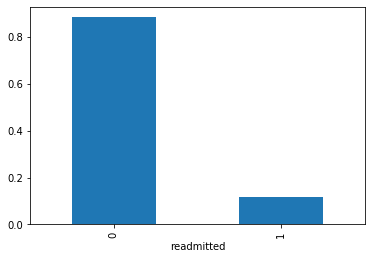

In [4]:
(df.groupby('readmitted').count()).iloc[:,0].apply(lambda x: x/df.shape[0]).plot(kind='bar')


In [5]:
y = df['readmitted'].apply(lambda x: 1 if x=='Yes' else 0)

In [29]:

#X = dummie
y = df['readmitted']
X = df.drop(columns=['readmitted'])
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.1, random_state=0)

X_train, X_train_lr, y_train, y_train_lr = ms.train_test_split(
    X_train, y_train, test_size=0.5)

In [30]:
y_train.value_counts().apply(lambda x: 100*x/y_train.shape[0])

0    88.417525
1    11.582475
Name: readmitted, dtype: float64

In [35]:
y_train_lr.value_counts().apply(lambda x: 100*x/y_train_lr.shape[0])

0    88.509562
1    11.490438
Name: readmitted, dtype: float64

In [36]:
y_test.value_counts().apply(lambda x: 100*x/y_test.shape[0])

0    88.349929
1    11.650071
Name: readmitted, dtype: float64

In [37]:
print(X_train.shape, X_train_lr.shape, X_test.shape)

(31634, 47) (31635, 47) (7030, 47)


In [38]:
# Random Forest,  and + Logistic Regression

n_estimator = 10
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder(categories='auto')
rf_lm = LogisticRegression(solver='saga', max_iter=1000, C=100, random_state=42)
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)
auc_rf_lm = auc(fpr_rf_lm, tpr_rf_lm)


In [41]:
# Gradient Boosting, and + Logistic Regression

n_estimator = 200
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder(categories='auto')
grd_lm = LogisticRegression(solver='saga', max_iter=1000, C=100, random_state=42)
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)
auc_grd_lm = auc(fpr_grd_lm, tpr_grd_lm)

y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
auc_grd = auc(fpr_grd, tpr_grd)


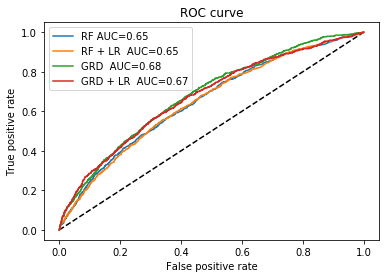

In [40]:

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF AUC={:.2f}'.format(auc_rf))
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR  AUC={:.2f}'.format(auc_rf_lm))
plt.plot(fpr_grd, tpr_grd, label='GRD  AUC={:.2f}'.format(auc_grd))
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GRD + LR  AUC={:.2f}'.format(auc_grd_lm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
